# 卷积模块介绍
前面我们介绍了卷积网络的基本知识，其在计算机视觉领域被应用得非常广泛，那么常见的卷机网络中用到的模块能够使用 pytorch 非常轻松地实现，下面我们来讲一下 pytorch 中的卷积模块

## 卷积
卷积在 pytorch 中有两种方式，一种是 `torch.nn.Conv2d()`，一种是 `torch.nn.functional.conv2d()`，这两种形式本质都是使用一个卷积操作

这两种形式的卷积对于输入的要求都是一样的，<span class="mark">首先需要输入是一个 `torch.autograd.Variable()` 的类型</span>，大小是 (batch, channel, H, W)，其中 batch 表示输入的一批数据的数目，第二个是输入的通道数，一般一张彩色的图片是 3，灰度图是 1，而卷积网络过程中的通道数比较大，会出现几十到几百的通道数，H 和 W 表示输入图片的高度和宽度，<span class="mark">比如一个 batch 是 32 张图片，每张图片是 3 通道，高和宽分别是 50 和 100，那么输入的大小就是 (32, 3, 50, 100)</span>
<span class="girk">这也是所谓的进行具体的分析，一个batch一个batch的训练好不好</span>
下面举例来说明一下这两种卷积方式

In [1]:
import numpy as np
import torch
from torch import nn
from torch.autograd import Variable
import torch.nn.functional as F
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
im = Image.open('./cat.png').convert('L') # 读入一张灰度图的图片
im = np.array(im, dtype='float32') # 将其转换为一个矩阵，转成一个np形式

<span class="mark">因为我们要明白matplotlib只能用array来可视化</span>

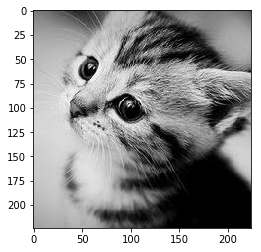

In [5]:
# 可视化图片
plt.imshow(im.astype('uint8'), cmap='gray')#因为我们要明白matplotlib只能用array来可视化

<span class="mark">下边是将所谓array的格式来画成tensor的具体形式好不好，利用Torch.from_numpy(),维度也要强行弄成4个维度
 (batch, channel, H, W)</span>

In [8]:
# 将图片矩阵转化为 pytorch tensor，并适配卷积输入的要求
im = torch.from_numpy(im.reshape((1, 1, im.shape[0], im.shape[1]))) 

下面我们定义一个算子对其进行轮廓检测

<div class="mark">
两种方法自己对filter来进行赋值</div><i class="fa fa-lightbulb-o "></i>

<div class="mark">
方法一</div><i class="fa fa-lightbulb-o "></i>

In [9]:
# 使用 nn.Conv2d
conv1 = nn.Conv2d(1, 1, 3, bias=False) # 定义卷积没有问题

sobel_kernel = np.array([[-1, -1, -1], [-1, 8, -1], [-1, -1, -1]], dtype='float32') # 定义轮廓检测算子
sobel_kernel = sobel_kernel.reshape((1, 1, 3, 3)) # 适配卷积的输入输出，filter的要适配具体的图片
conv1.weight.data = torch.from_numpy(sobel_kernel) # 给卷积的 kernel 赋值

edge1 = conv1(Variable(im)) # 注意输入的一定是variable格式，输出也是variable格式
edge1 = edge1.data.squeeze().numpy() # 将输出转换为图片的格式，要换成numpy格式 squeeze（）是将1的维度全部弄掉
#比如说（1,1,2,3） 变成（2,3）

下面我们可视化边缘检测之后的结果

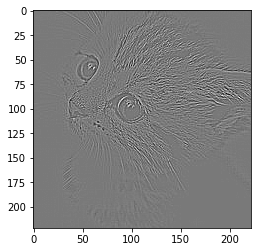

In [10]:
plt.imshow(edge1, cmap='gray')

<div class="mark">
第二种</div><i class="fa fa-lightbulb-o "></i>

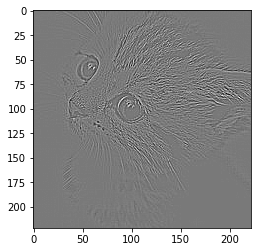

In [16]:
# 使用 F.conv2d
sobel_kernel = np.array([[-1, -1, -1], [-1, 8, -1], [-1, -1, -1]], dtype='float32') # 定义轮廓检测算子
sobel_kernel = sobel_kernel.reshape((1, 1, 3, 3)) # 适配卷积的输入输出
weight = Variable(torch.from_numpy(sobel_kernel))

edge2 = F.conv2d(Variable(im), weight) # 作用在图片上
edge2 = edge2.data.squeeze().numpy() # 将输出转换为图片的格式
plt.imshow(edge2, cmap='gray')

<span class="mark">不同的filter提取的特征也不一致</span>

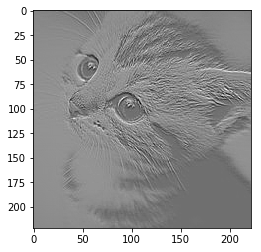

In [17]:
# 使用 F.conv2d
sobel_kernel = np.array([[-1, -5, -1], [1, 8, -1], [-1, 3, -1]], dtype='float32') # 定义轮廓检测算子
sobel_kernel = sobel_kernel.reshape((1, 1, 3, 3)) # 适配卷积的输入输出
weight = Variable(torch.from_numpy(sobel_kernel))

edge2 = F.conv2d(Variable(im), weight) # 作用在图片上
edge2 = edge2.data.squeeze().numpy() # 将输出转换为图片的格式
plt.imshow(edge2, cmap='gray')

可以看到两种形式能够得到相同的效果，不同的地方相信你也看到了，<span class="burk">使用 `nn.Conv2d()` 相当于直接定义了一层卷积网络结构</span>，<span class="mark">而使用 `torch.nn.functional.conv2d()` 相当于定义了一个卷积的操作，所以使用后者需要再额外去定义一个 weight，而且这个 weight 也必须是一个 Variable</span>，而使用 `nn.Conv2d()` 则会帮我们默认定义一个随机初始化的 weight，如果我们需要修改，那么取出其中的值对其修改，如果不想修改，那么可以直接使用这个默认初始化的值，非常方便

**实际使用中我们基本都使用 `nn.Conv2d()` 这种形式**

## 池化层
卷积网络中另外一个非常重要的结构就是池化，这是利用了图片的下采样不变性，即一张图片变小了还是能够看出了这张图片的内容，而使用池化层能够将图片大小降低，非常好地提高了计算效率，<span class="mark">同时池化层也没有参数</span>。池化的方式有很多种，比如最大值池化，均值池化等等，在卷积网络中一般使用最大值池化。

在 pytorch 中最大值池化的方式也有两种，一种是 `nn.MaxPool2d()`，一种是 `torch.nn.functional.max_pool2d()`，他们对于图片的输入要求跟卷积对于图片的输入要求是一样了，就不再赘述，下面我们也举例说明

<div class="mark">
第一种最大池化方法</div><i class="fa fa-lightbulb-o "></i>

In [18]:
# 使用 nn.MaxPool2d
pool1 = nn.MaxPool2d(2, 2)
print('before max pool, image shape: {} x {}'.format(im.shape[2], im.shape[3]))
small_im1 = pool1(Variable(im))
small_im1 = small_im1.data.squeeze().numpy()
print('after max pool, image shape: {} x {} '.format(small_im1.shape[0], small_im1.shape[1]))

before max pool, image shape: 224 x 224
after max pool, image shape: 112 x 112 


可以看到图片的大小减小了一半，那么图片是不是变了呢？我们可以可视化一下

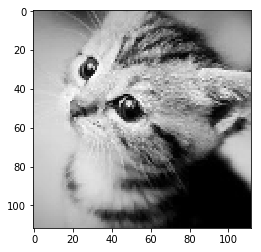

In [29]:
plt.imshow(small_im1, cmap='gray')

可以看到图片几乎没有变化，说明池化层只是减小了图片的尺寸，并不会影响图片的内容

<div class="mark">
第二种最大池化方法</div><i class="fa fa-lightbulb-o "></i>

before max pool, image shape: 224 x 224
after max pool, image shape: 112 x 112 


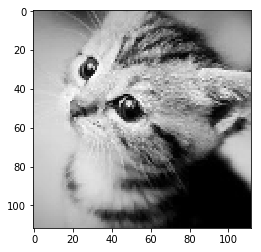

In [30]:
# F.max_pool2d
print('before max pool, image shape: {} x {}'.format(im.shape[2], im.shape[3]))
small_im2 = F.max_pool2d(Variable(im), 2, 2)
small_im2 = small_im2.data.squeeze().numpy()
print('after max pool, image shape: {} x {} '.format(small_im1.shape[0], small_im1.shape[1]))
plt.imshow(small_im2, cmap='gray')

**跟卷积层一样，实际使用中，我们一般使用 `nn.MaxPool2d()`**

以上我们介绍了如何在 pytorch 中使用卷积网络中的卷积模块和池化模块，接下来我们会开始讲卷积网络中几个非常著名的网络结构